In [1]:
from pathlib import Path
import dill as pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

pd.set_option("display.max_columns", None)  # Display all columns

plt.style.use("ggplot")

In [2]:
interim_data_dir = Path(Path.cwd().parent, "data", "interim")
processed_data_dir = Path(Path.cwd().parent, "data", "processed")
X_test_raw = pd.read_pickle(Path(interim_data_dir, "X_test.pkl"))
X_test = pd.read_pickle(Path(processed_data_dir, "X_test_transformed.pkl"))
y_test = pd.read_pickle(Path(interim_data_dir, "y_test.pkl"))

In [3]:
y_test.shape, X_test.shape

((20000,), (20000, 115))

In [4]:
save_trained_model_dir = Path(Path.cwd().parent, "models")
xgb_model = "XGBoost - default params.pkl"
with open(Path(save_trained_model_dir, xgb_model), "rb") as f:
    XGBoostDefault = pickle.load(f)

# Making Predictions

In [5]:
clf = XGBoostDefault.clf
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)
proba_zero = probas[:, 0]
proba_one = probas[:, 1]

# Final Scores

In [6]:
f1_test_score = (f1_score(y_test, preds),)
precision_test_score = (precision_score(y_test, preds),)
recall_test_score = recall_score(y_test, preds)

In [7]:
results = pd.DataFrame.from_dict(
    {
        "F1": f1_test_score,
        "Precision": precision_test_score,
        "Recall": recall_test_score,
    }
)
results

,F1,Precision,Recall
0,0.838174,0.943925,0.753731


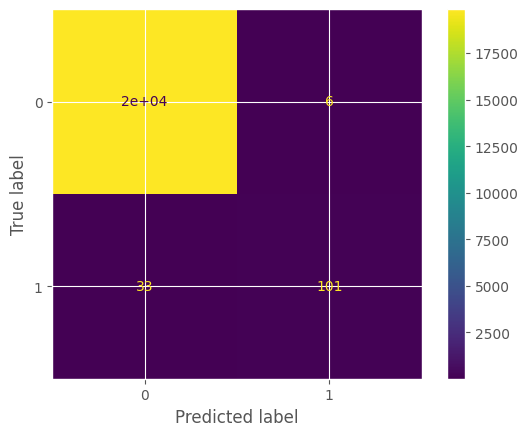

In [8]:
cm = confusion_matrix(y_test, preds, labels=np.array([0, 1]))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array([0, 1]))
disp.plot()

# Assigning Risk

We can use the probability of churning to assign a risk profile. The correct value for this would need to be worked out with the client, for now we will say any customer with a risk higher than 75% of churning is "high risk".

In [9]:
HIGH_RISK_VALUE = 0.75
X_test_raw["Prediction"] = preds
X_test_raw["Probability_zero"] = proba_zero
X_test_raw["Probability_one"] = proba_one
risk_profiles_list = ["High" if x >= HIGH_RISK_VALUE else "Low" for x in proba_one]
X_test_raw["Risk Profile"] = risk_profiles_list

In [10]:
X_test_raw[X_test_raw["Risk Profile"] == "High"]

,SALESFORCEACCOUNTID,ACCOUNTING_MONTH,RENEWAL_MONTH,CONTRACT_START_DATE,REGION,SECTOR,TENURE_MONTHS,DNB_GLOBAL_SALES_REVENUE,DNB_GLOBAL_EMPLOYEE_COUNT,CONTRACT_LENGTH,ARR,SEATS,COMPETITOR_SEATS,DETECTEDSEATSCOUNT,PRODUCT_ONE,PRODUCT_TWO,PRODUCT_THREE,PRODUCT_FOUR,PRODUCT_FIVE,PRODUCT_SIX,PRODUCT_SEVEN,PRODUCT_EIGHT,PRODUCT_NINE,PRODUCT_TEN,PRODUCT_ELEVEN,PRODUCT_TWELVE,PRODUCT_THIRTEEN,PRODUCT_FOURTEEN,PRODUCT_FIFTEEN,PRODUCT_SIXTEEN,PRODUCT_SEVENTEEN,PRODUCT_EIGHTEEN,PRODUCT_NINETEEN,PRODUCT_TWENTY,PRODUCT_TWENTYONE,PRODUCT_TWENTYTWO,PRODUCT_TWENTYTHREE,LICENSINGSPECIALIST_CHANGE,SALESREP_CHANGE,UPSELLMANAGER_CHANGE,ACCOUNTMANAGER_CHANGE,CHURN_RISK_DISCUSSION,CUSTOMER_HEALTH_CHECK,CS_EVENT_ATTENDED,CROSS_SELL_RECENCY,SEATS_DOWNSELL_RECENCY,PRODUCT_DOWNSELL_RECENCY,SEATS_UPSELL_RECENCY,PCT_PRODUCT_TWO_ENABLED,PCT_PRODUCT_THREE_ENABLED,PCT_PRODUCT_FOUR_ENABLED,PCT_PRODUCT_FIVE_ENABLED,PCT_PRODUCT_SIX_ENABLED,PCT_PRODUCT_NINE_ENABLED,PCT_PRODUCT_TWO_BEST_PRACTICE,PCT_PRODUCT_THREE_BEST_PRACTICE,PCT_PRODUCT_FOUR_BEST_PRACTICE,CUSTOMER_BEHAVIOUR_ONE,CUSTOMER_BEHAVIOUR_TWO,CUSTOMER_BEHAVIOUR_THREE,CUSTOMER_BEHAVIOUR_FOUR,CUSTOMER_BEHAVIOUR_FIVE,CUSTOMER_BEHAVIOUR_SIX,CUSTOMER_BEHAVIOUR_SEVEN,CUSTOMER_BEHAVIOUR_EIGHT,CUSTOMER_BEHAVIOUR_NINE,CUSTOMER_BEHAVIOUR_TEN,CUSTOMER_BEHAVIOUR_ELEVEN,MAX_SUPPORT_CASE_DAYSTOCLOSE,MAX_SUPPORT_CASE_TIMETOFIRSTRESPONSE,AVG_SUPPORT_CASE_PRIORITY_SCORE,SUM_SEVERE_CASES,SUM_HIGH_CASES,SUM_MEDIUM_CASES,SUM_LOW_CASES,SUM_STANDARD_CASES,SUPPORT_CASE_NUMBEROFSLABREACHES,BACKLOG,SURVEY_AVG_CXI_SCORE,SURVEY_AVG_NPS_SCORE,SURVEY_AVG_CASE_MOOD_SCORE,Prediction,Probability_zero,Probability_one,Risk Profile
81642,0011N00001aYYNvQAO,2023-02-01 00:00:00+00:00,2023-02-01T00:00:00Z,2022-02-16T00:00:00Z,RSA,Finance,72,NaN,NaN,364,0.0,1000,0,0.001000,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0.0,0,0,0,0,0,0,2,NaN,NaN,NaN,1,0.023328,0.976672,High
55485,0011N00001aYqE1QAK,2022-05-01 00:00:00+00:00,2022-05-01T00:00:00Z,2022-02-10T00:00:00Z,USA,Finance,51,6.325738e+07,181.0,88,0.0,120,0,0.000000,1,0,0,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,2,24,0,0,0,0,0,0,0,0,0,0,0,2629,0,0,0,6,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,4,NaN,NaN,NaN,1,0.026176,0.973824,High
40736,0011N00001aYuyuQAC,2020-09-01 00:00:00+00:00,2020-09-01T00:00:00Z,2020-03-27T00:00:00Z,USA,Retail & Wholesale,17,NaN,NaN,183,0.0,710,452,0.615493,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,0.001863,0.998137,High
85456,0011N00001aYYQUQA4,2020-09-01 00:00:00+00:00,2020-09-01T00:00:00Z,2019-09-30T00:00:00Z,RSA,Government,23,NaN,NaN,365,0.0,17,0,0.000000,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,0.012764,0.987236,High
78308,0011N00001aYYLMQA4,2020-07-01 00:00:00+00:00,2020-07-01T00:00:00Z,2020-04-11T00:00:00Z,RSA,Other,28,NaN,NaN,90,0.0,3,0,1.000000,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,NaN,NaN,NaN,1,0.172696,0.827304,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93392,0011N00001aYhFbQAK,2020-08-01 00:00:00+00:00,2020-08-01T00:00:00Z,2019-08-23T00:00:00Z,UKI,Finance,76,NaN,NaN,365,0.0,81,0,0.000000,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,2,0,0,NaN,NaN,NaN,1,0.042554,0.957446,High
6043,0011N00001hCNAtQAO,2020-11-01 00:00:00+00:00,2020-10-01T00:00:00Z,2019-11-01T00:00:00Z,USA,Professional Services,24,3.138370e+08,495.0,36